# Classificação de digitos utilizando o framework tensorflow
[dataset dowload](https://www.kaggle.com/oddrationale/mnist-in-csv)

In [1]:
# importando bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import Normalizer # função para normalizar as imagens
import os


In [2]:
# lendo arquivo utilizando pandas 
data_train = pd.read_csv('/home/matthew/Área de Trabalho/deep_learning/datasets_locais/mnist/train/mnist_train.csv')

In [3]:
data_test = pd.read_csv('/home/matthew/Área de Trabalho/deep_learning/datasets_locais/mnist/test/mnist_test.csv')

In [4]:
# visualizando amostras
data_test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# retirando os rotulos para organizar os arrays 
train_x = data_train.drop('label', axis=1).values 
test_x  = data_test.drop('label', axis=1).values

# separando os rotulos
train_y = data_train['label'].values
test_y  = data_test['label'].values

In [6]:
train_x.shape # verificando dimenções

(60000, 784)

In [7]:
train_y.shape # os labels devem ser convertidos para one_hot_encoding

(60000,)

## One-Hot Encoding
![One-hot Encoding](https://cdn-images-1.medium.com/max/1200/1*3hdYEX5eixaV4F3wT5OmBg.png)
fonte: [https://medium.com/data-design/](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)

One-hot Encoding é um processo de conversão de classes em probabilidades.
Basicamente pega uma classe e atribui o valor 1, enquanto as outras recebem 0.

In [8]:
# funcãp para converter classes em probabilidades 
def one_hot(labels, num_classes):
    num_labels = labels.shape[0]
    indexoffset = np.arange(num_labels)*num_classes
    labels_one_hot = np.zeros([num_labels, num_classes])
    labels_one_hot.flat[indexoffset + labels.ravel()] = 1
    return labels_one_hot

In [9]:
# será retirado do conjunto de treino 20% das imagens para validação durante o treino
def validation_set(x, y, size=0.2):
    data_points = len(x)
    indices = list(range(data_points))
    np.random.shuffle(indices)
    validset_x = []
    validset_y = []
    split = int(np.floor(size*data_points))
    for i in indices[0:split]:
        validset_x.append(x[i])
        validset_y.append(y[i])
    
    return ( np.array(validset_x), np.array(validset_y) ), (x[split:], y[split:])
        

In [10]:
# para evitar problemas de memoria RAM, as imagens serão amostradas em lotes de tamanho size=
def batch_loader(data_x, data_y, size):
    inicio, fim = 0, size
    tamanho = len(data_x)//size
    for i in range(tamanho):
        yield data_x[inicio:fim], data_y[inicio:fim]
        if i != (tamanho - 1):
            inicio += size
            fim += size
        else:
            inicio += size
            fim += len(data_x)%size
            if (len(data_x)%size) != 0:
                yield data_x[inicio:fim], data_y[inicio:fim]
    

In [11]:
# as imagens serão normalizadas, e o valor dos pixels ajustados entre 0 e 1
# formula valor_pixel / 255
def pre_proc(dataset):
    transformer = Normalizer(norm='max').fit(dataset)
    return transformer.transform(dataset)

In [12]:
np.max(train_x) # as imagens precisam ser normalizadas

255

In [13]:
test_x = pre_proc(test_x)
train_x = pre_proc(train_x)

In [14]:
# one_hot_encoding
train_y = one_hot(train_y, 10)
test_y = one_hot(test_y, 10)

In [15]:
test_y.shape # converção bem sucedida!

(10000, 10)

In [16]:
(val_x, val_y), (train_x, train_y) = validation_set(train_x, train_y) # cojunto de validação

In [17]:
np.max(val_x)

1.0

## Definindo a arquitetura da rede

In [18]:
tf.set_random_seed(1234) # definindo semente aleatória

In [19]:
input_units = 784 # número de unidades de entrada
hidden_units = 500 # unidades ocultas
output_units = 10 # saida

In [20]:
tf.reset_default_graph()
with tf.variable_scope('Inputs'): # criando um escopo 
    x = tf.placeholder(tf.float32, [None, input_units]) # placeholder para ps dados de entrada
with tf.variable_scope('Labels'):
    y = tf.placeholder(tf.float32, [None, output_units]) # placeholder para os rotulos

In [21]:
# criando parâmetros 
weights = {
    'hidden':tf.Variable(tf.random_normal((input_units, hidden_units )), tf.float32, name='W1'),
    'output':tf.Variable(tf.random_normal((hidden_units, output_units)), tf.float32, name='Wout')
}
biases = {
    'hidden':tf.Variable(tf.random_normal([hidden_units]), tf.float32, name='B1'),
    'output':tf.Variable(tf.random_normal([output_units]), tf.float32, name='Bout')
}

In [22]:
with tf.variable_scope('MPL'): # escopo
    fc1 = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])# primeira camada totalmente conectada
    fc1 = tf.nn.relu(fc1) # aplicando a função relu
    logits = tf.add(tf.matmul(fc1, weights['output']), biases['output']) # obtendo logits
    prediction = tf.nn.softmax(logits)# obetendo predições

In [23]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))# funcão de custo
optim = tf.train.GradientDescentOptimizer(learning_rate=0.01) # otimizador
grad_and_vars = optim.compute_gradients(loss) # armazenando gradientes
optimizer = optim.minimize(loss)
init = tf.global_variables_initializer() # inicializador de variaveis

# definindo calculo de acuracia 
pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1)) 
accuracy = tf.reduce_mean(tf.cast(pred, tf.float32))


In [24]:
# tensorboard
# placeholders para loss e acurácia
with tf.name_scope('performance'):
    tf_loss_ph = tf.placeholder(tf.float32, shape=None, name='loss_summary')
    tf_loss_summary = tf.summary.scalar('loss', tf_loss_ph)
    
    tf_accuracy_ph = tf.placeholder(tf.float32, shape=None, name='accuracy_summary')
    tf_accuracy_summary = tf.summary.scalar('accuracy', tf_accuracy_ph)
    
# calculando a norma L2 dos gradientes
for g, v in grad_and_vars:
        with tf.name_scope('gradientes'):
            tf_last_grad_norm = tf.sqrt(tf.reduce_mean(g**2))
            tf_grad_norm_summary = tf.summary.scalar('grad_norm', tf_last_grad_norm)
            break
performance_summaries = tf.summary.merge([tf_loss_summary, tf_accuracy_summary])            


In [25]:
epochs = 40 # número de epocas
batch_size = 32

# salvando losses
valid_losses = []
train_losses = []
saver = tf.train.Saver()
save_path = '/home/matthew/anaconda3/envs/skynet/tensorflow/digits_classifier/test3/'
min_val_loss = np.inf

In [26]:
with tf.Session() as ses:
    
    # criando pastas para os eventos do tensorboard
    #----------------------------------------------------
    if not os.path.exists('summaries'):
        os.mkdir('summaries')
    if not os.path.exists(os.path.join('summaries', 'second')):
        os.mkdir(os.path.join('summaries', 'second'))
    #----------------------------------------------------
    summ_writer = tf.summary.FileWriter(os.path.join('summaries', 'second'), ses.graph)
    
    
    ses.run(init)
    for ep in range(epochs):
        running_loss = 0.0
        val_loss = 0.0
        #treinamento
        for images, labels in batch_loader(train_x, train_y, batch_size):
            if running_loss == 0.0:
                _, c, grad_norm = ses.run([optimizer, loss, tf_grad_norm_summary], {x:images.reshape(-1, 784), y:labels})
                running_loss += ( c / ( (len(train_x)//batch_size) + (len(train_x)%batch_size)))
            else:
                _, c = ses.run([optimizer, loss], {x:images.reshape(-1, 784), y:labels})
                running_loss += ( c / ( (len(train_x)//batch_size) + (len(train_x)%batch_size)))      
        summ_writer.add_summary(grad_norm, ep)
        # validação
        for data, target in batch_loader(val_x, val_y, batch_size):
            cost, a = ses.run([loss, accuracy], {x:data.reshape(-1, 784), y:target})
            val_loss += ( cost / ( (len(val_x)//batch_size) + (len(val_x)%batch_size)))
        summa = ses.run(performance_summaries, {tf_loss_ph:val_loss, tf_accuracy_ph:a})
        
        summ_writer.add_summary(summa, ep)
        
        valid_losses.append(val_loss)
        train_losses.append(running_loss)
        print('epoch: {} train_loss: {:.5f} valid_loss: {:.5f}'.format(ep+1, running_loss, val_loss))
        
        # salvando melhores parâmetros
        if min_val_loss > val_loss:
            saver.save(ses, save_path+'meu_modelo')
            print('saving...')
            min_val_loss = val_loss
        
    # teste
    acc = ses.run(accuracy, {x:test_x, y:test_y})
    print('Total accuracy: {:.2f}'.format(acc))

   
    
    
        
                    

epoch: 1 train_loss: 14.25704 valid_loss: 6.82600
saving...
epoch: 2 train_loss: 5.65415 valid_loss: 4.78721
saving...
epoch: 3 train_loss: 4.11866 valid_loss: 3.66461
saving...
epoch: 4 train_loss: 3.23055 valid_loss: 2.95870
saving...
epoch: 5 train_loss: 2.65289 valid_loss: 2.48228
saving...
epoch: 6 train_loss: 2.23523 valid_loss: 2.12088
saving...
epoch: 7 train_loss: 1.90872 valid_loss: 1.86517
saving...
epoch: 8 train_loss: 1.66307 valid_loss: 1.71061
saving...
epoch: 9 train_loss: 1.45671 valid_loss: 1.59073
saving...
epoch: 10 train_loss: 1.28141 valid_loss: 1.44642
saving...
epoch: 11 train_loss: 1.13772 valid_loss: 1.31583
saving...
epoch: 12 train_loss: 1.01885 valid_loss: 1.19463
saving...
epoch: 13 train_loss: 0.91451 valid_loss: 1.16308
saving...
epoch: 14 train_loss: 0.83043 valid_loss: 1.08504
saving...
epoch: 15 train_loss: 0.75103 valid_loss: 1.01765
saving...
epoch: 16 train_loss: 0.67394 valid_loss: 0.99254
saving...
epoch: 17 train_loss: 0.61689 valid_loss: 0.9398

Text(0, 0.5, 'loss')

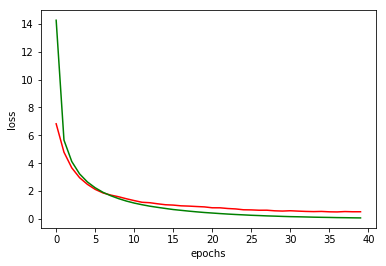

In [27]:
plt.plot(valid_losses, 'r-' )
plt.plot(train_losses, 'g-')

plt.xlabel('epochs')
plt.ylabel('loss')